In [1]:
import rospy
from sensor_msgs.msg import Image
from cv_bridge import CvBridge
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from std_msgs.msg import Float64
from dynamixel_sdk import *
import datetime
import threading
import serial
import re
import pandas as pd
import glob


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

/tmp/ipykernel_58405/2284580335.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
%%javascript

window.scroll_flag = true
window.scroll_exit = false
window.scroll_delay = 100

$(".output_scroll").each(function() {
    $(this)[0].scrollTop = $(this)[0].scrollHeight;
});

function callScrollToBottom() {
    setTimeout(scrollToBottom, window.scroll_delay);
}

function scrollToBottom() {
    if (window.scroll_exit) {
        return;
    }
    if (!window.scroll_flag) {
        callScrollToBottom();
        return;
    };
    
    $(".output_scroll").each(function() {
        if (!$(this).attr('scroll_checkbox')){
            window.scroll_flag = true;
            $(this).attr('scroll_checkbox',true);
            var div = document.createElement('div');
            var checkbox = document.createElement('input');
            checkbox.type = "checkbox";
            checkbox.onclick = function(){window.scroll_flag = checkbox.checked}
            checkbox.checked = "checked"
            div.append("Auto-Scroll-To-Bottom: ");
            div.append(checkbox);
            $(this).parent().before(div);
        }
        
        $(this)[0].scrollTop = $(this)[0].scrollHeight;
    });
    callScrollToBottom();
}
scrollToBottom();

<IPython.core.display.Javascript object>

In [4]:
class Dynamixel_motor:
    def __init__(self, dxl_id, baudrate, device_name):
        self.dxl_id = dxl_id
        self.baudrate = baudrate
        self.device_name = device_name
        self.protocol_version = 2.0

        # Initialize PortHandler instance
        # Set the port path
        # Get methods and members of PortHandlerLinux or PortHandlerWindows
        self.portHandler = PortHandler(self.device_name)

        # Initialize PacketHandler instance
        # Set the protocol version
        # Get methods and members of Protocol1PacketHandler or Protocol2PacketHandler
        self.packetHandler = PacketHandler(self.protocol_version)

        # Open port
        if self.portHandler.openPort():
            print("Succeeded to open the port")
        else:
            print("Failed to open the port")
            print("Press any key to terminate...")
            self.close_port()

        # Set port baudrate
        if self.portHandler.setBaudRate(self.baudrate):
            print("Succeeded to change the baudrate")
        else:
            print("Failed to change the baudrate")
            print("Press any key to terminate...")
            self.close_port()

    def __del__(self):
        print('Destructor called.')
        self.portHandler.closePort()

    def close_port(self):
        self.torque_disable()
        self.portHandler.closePort()
        print('closing port.')

    def ping_motor(self):

        # Try to ping the Dynamixel
        # Get Dynamixel model number
        dxl_model_number, dxl_comm_result, dxl_error = self.packetHandler.ping(self.portHandler, self.dxl_id)
        print(f"dxl_model_number is: {dxl_model_number}")
        print(f"dxl_comm_result is: {dxl_comm_result}")
        print(f"dxl_error is: {dxl_error}")
        print(f"COMM_SUCCESS is {COMM_SUCCESS}")
        if dxl_comm_result != COMM_SUCCESS:
            print("statement 0")
            print("%s" % self.packetHandler.getTxRxResult(dxl_comm_result))
            self.close_port()
        elif dxl_error != 0:
            print("statement 1")
            print("%s" % self.packetHandler.getRxPacketError(dxl_error))
            self.close_port()
        else:
            print("statement 2")
            print("[ID:%03d] ping Succeeded. Dynamixel model number : %d" % (self.dxl_id, dxl_model_number))

    def torque_enable(self):
        TORQUE_ENABLE_REG = 64
        TORQUE_ENABLE = 1
        result, error = self.packetHandler.write4ByteTxRx(self.portHandler, self.dxl_id, TORQUE_ENABLE_REG, TORQUE_ENABLE)
        return

    def torque_disable(self):
        TORQUE_ENABLE_REG = 64
        TORQUE_ENABLE = 0
        result, error = self.packetHandler.write4ByteTxRx(self.portHandler, self.dxl_id, TORQUE_ENABLE_REG, TORQUE_ENABLE)
        return

    def read_operation_mode(self):
        OPERATING_MODE_REG = 11
        data, result, error = self.packetHandler.read1ByteTxRx(self.portHandler, self.dxl_id, OPERATING_MODE_REG)
        print(f"data is: {data}")
        print(f"result is: {result}")
        print(f"error is: {error}")
        return data

    def set_current_position_mode(self):
        OPERATING_MODE_REG = 11
        OPERATION_MODE = 5
        result, error = self.packetHandler.write1ByteTxRx(self.portHandler, self.dxl_id, OPERATING_MODE_REG, OPERATION_MODE)
        return

    def set_goal_current(self, GOAL_CURRENT):
        GOAL_CURRENT_REG = 102
        result, error = self.packetHandler.write2ByteTxRx(self.portHandler, self.dxl_id, GOAL_CURRENT_REG, GOAL_CURRENT)
        return

    def read_present_position(self):
        PRESENT_POSITION_REG = 132
        PRESENT_POSITION, result, error = self.packetHandler.read4ByteTxRx(self.portHandler, self.dxl_id, PRESENT_POSITION_REG)
        return PRESENT_POSITION

    def set_goal_position(self, GOAL_POSITION):
        GOAL_POSITION_REG = 116
        result, error = self.packetHandler.write4ByteTxRx(self.portHandler, self.dxl_id, GOAL_POSITION_REG, GOAL_POSITION)
        return

    def read_present_current(self):
        PRESENT_CURRENT_REG = 126
        PRESENT_CURRENT, result, error = self.packetHandler.read2ByteTxRx(self.portHandler, self.dxl_id, PRESENT_CURRENT_REG)
        return PRESENT_CURRENT


Succeeded to open the port
Succeeded to change the baudrate
data is: 5
result is: 0
error is: 0
Taring load cell...
[INFO] [1677541704.766859]: Timing images
Enter something: 
b'000.0,000.0,0383.8,0383.7\r\n'
[INFO] [1677541719.079598]: Image received...


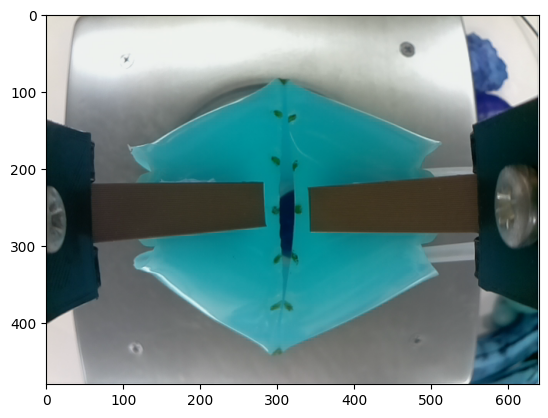

b'100.6,048.1,0309.6,0309.1\r\n'
Data number 1
['100.6', '048.1', '0309.6', '0309.1']
b'098.9,047.1,0383.6,0248.5\r\n'
['098.9', '047.1', '0383.6', '0248.5']
Enter something: 
b'000.0,000.0,0363.3,0363.2\r\n'
[INFO] [1677541731.106616]: Image received...


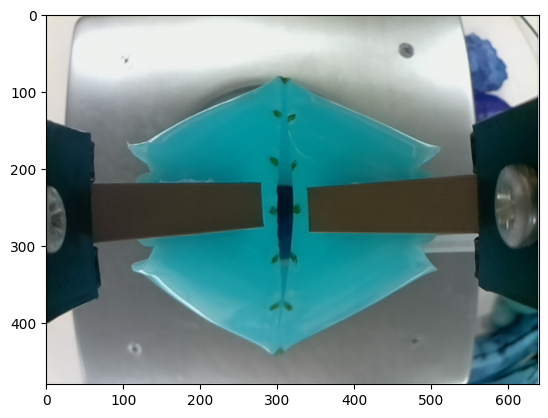

b'095.9,061.8,0317.9,0317.3\r\n'
Data number 2
['095.9', '061.8', '0317.9', '0317.3']
b'094.1,059.6,0390.2,0254.8\r\n'
['094.1', '059.6', '0390.2', '0254.8']
Enter something: 
b'000.0,000.0,0361.0,0360.7\r\n'
[INFO] [1677541742.858740]: Image received...


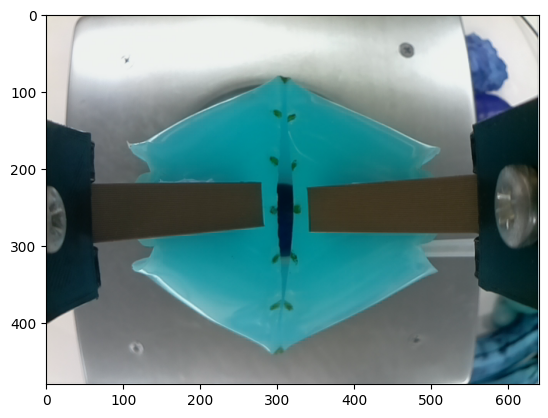

b'095.4,083.5,0314.2,0313.9\r\n'
Data number 3
['095.4', '083.5', '0314.2', '0313.9']
b'094.1,080.9,0387.0,0251.6\r\n'
['094.1', '080.9', '0387.0', '0251.6']
Enter something: 
b'000.0,000.0,0368.0,0367.7\r\n'
[INFO] [1677541771.858840]: Image received...


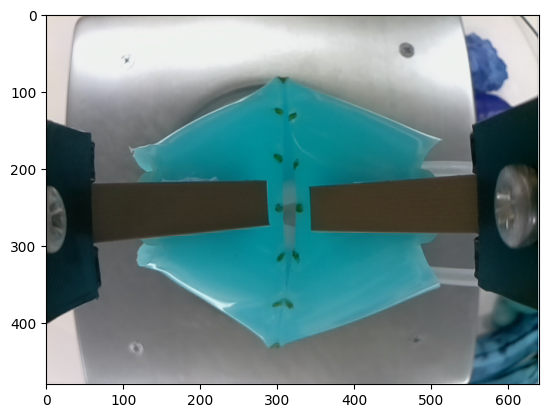

b'049.3,049.4,0284.3,0283.8\r\n'
Data number 4
['049.3', '049.4', '0284.3', '0283.8']
b'048.3,048.9,0358.6,0223.6\r\n'
['048.3', '048.9', '0358.6', '0223.6']
Enter something: 
b'000.0,000.0,0360.9,0360.5\r\n'
[INFO] [1677541784.111628]: Image received...


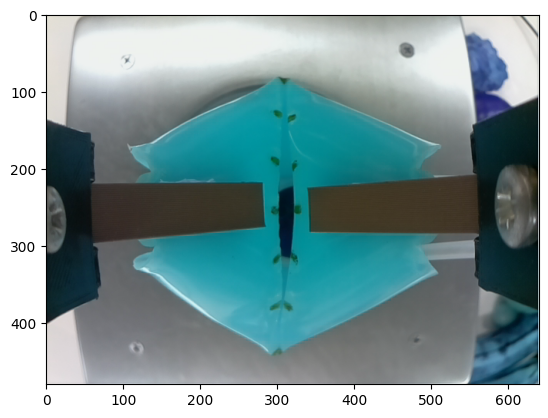

b'073.5,069.1,0314.8,0314.2\r\n'
Data number 5
['073.5', '069.1', '0314.8', '0314.2']
b'073.4,068.2,0387.3,0252.0\r\n'
['073.4', '068.2', '0387.3', '0252.0']
Enter something: 
b'000.0,000.0,0359.3,0359.1\r\n'
[INFO] [1677541796.355300]: Image received...


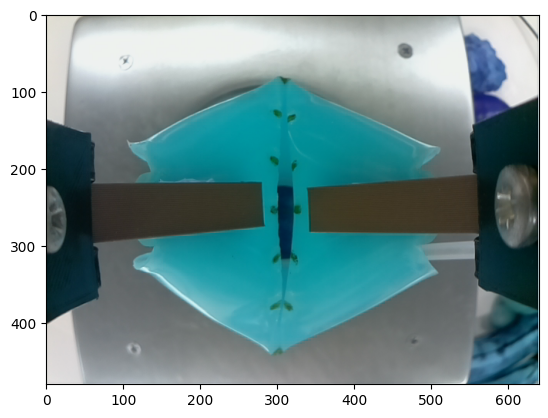

b'093.6,063.2,0314.7,0314.2\r\n'
Data number 6
['093.6', '063.2', '0314.7', '0314.2']
b'091.8,062.7,0387.5,0252.2\r\n'
['091.8', '062.7', '0387.5', '0252.2']
Enter something: 
b'000.0,000.0,0361.3,0361.2\r\n'
[INFO] [1677541809.891309]: Image received...


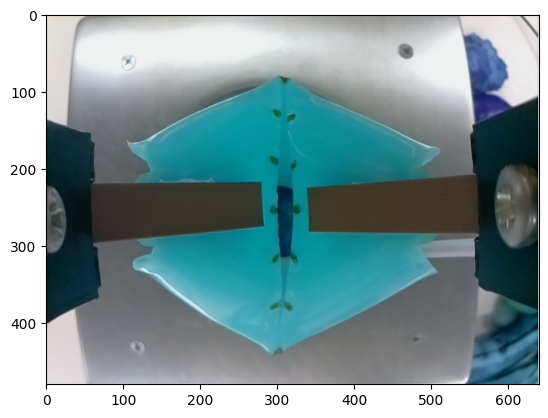

b'082.9,070.2,0316.3,0315.5\r\n'
Data number 7
['082.9', '070.2', '0316.3', '0315.5']
b'081.3,069.7,0388.0,0252.7\r\n'
['081.3', '069.7', '0388.0', '0252.7']
Enter something: 
b'000.0,000.0,0368.4,0368.3\r\n'
[INFO] [1677542171.605484]: Image received...


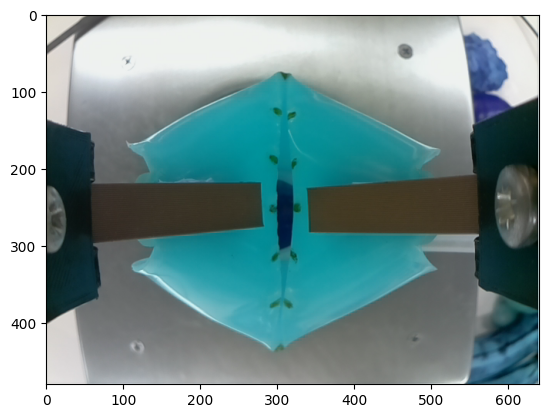

b'077.6,084.0,0323.4,0322.8\r\n'
Data number 8
['077.6', '084.0', '0323.4', '0322.8']
b'072.2,080.8,0393.4,0258.4\r\n'
['072.2', '080.8', '0393.4', '0258.4']
Enter something: 
b'000.0,000.0,0363.2,0363.3\r\n'
[INFO] [1677542188.858217]: Image received...


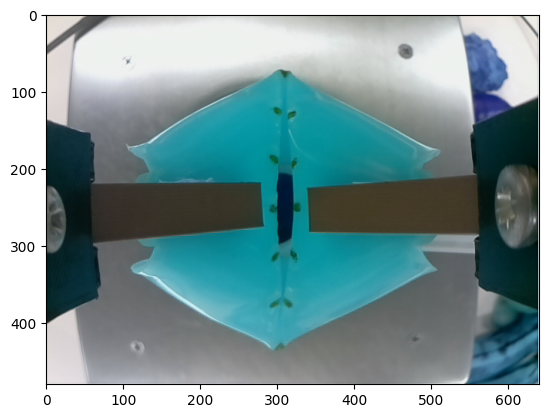

b'053.6,095.1,0326.6,0327.5\r\n'
Data number 9
['053.6', '095.1', '0326.6', '0327.5']
b'055.1,094.0,0397.4,0262.6\r\n'
['055.1', '094.0', '0397.4', '0262.6']
Enter something: 
b'000.0,000.0,0352.6,0352.1\r\n'
[INFO] [1677542200.607125]: Image received...


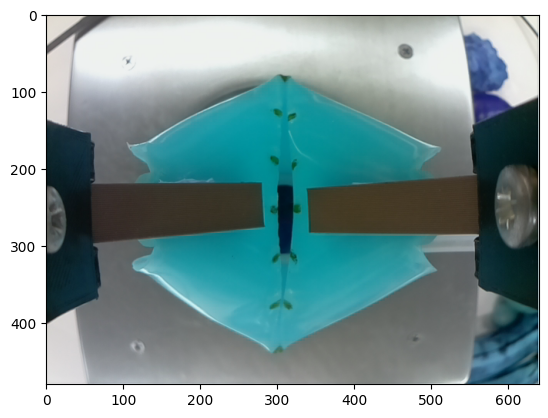

b'069.7,078.8,0317.7,0317.4\r\n'
Data number 10
['069.7', '078.8', '0317.7', '0317.4']
b'068.6,078.6,0390.0,0255.1\r\n'
['068.6', '078.6', '0390.0', '0255.1']
Enter something: 
b'000.0,000.0,0359.0,0359.1\r\n'
[INFO] [1677542214.111565]: Image received...


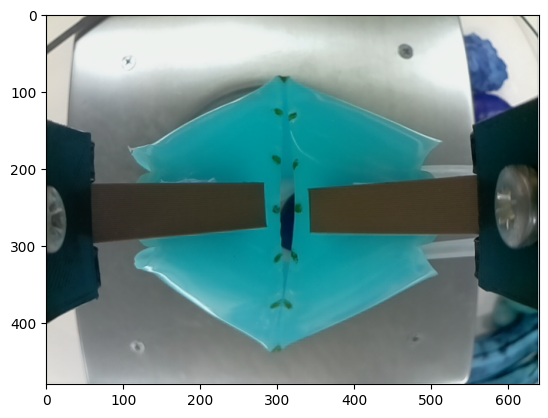

b'068.0,085.1,0308.1,0307.4\r\n'
Data number 11
['068.0', '085.1', '0308.1', '0307.4']
b'066.8,083.4,0381.9,0247.2\r\n'
['066.8', '083.4', '0381.9', '0247.2']
Enter something: 
b'000.0,000.0,0355.6,0355.7\r\n'
[INFO] [1677542226.108787]: Image received...


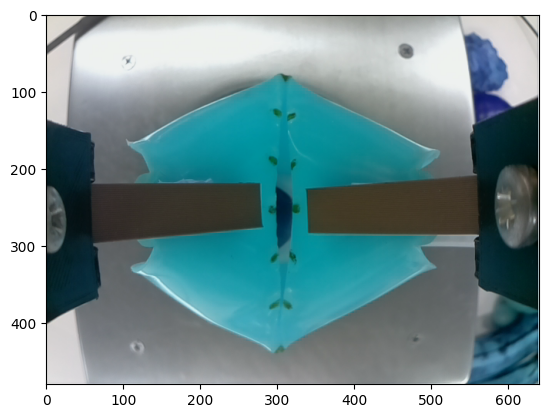

b'066.9,073.2,0321.4,0321.5\r\n'
Data number 12
['066.9', '073.2', '0321.4', '0321.5']
b'066.5,073.2,0391.0,0255.9\r\n'
['066.5', '073.2', '0391.0', '0255.9']
Enter something: 
b'000.0,000.0,0357.8,0358.0\r\n'
[INFO] [1677542239.618183]: Image received...


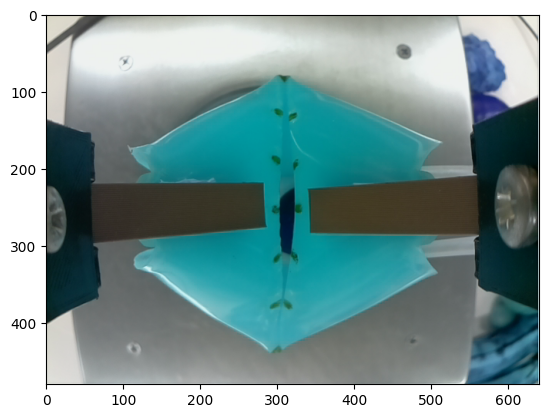

b'075.6,077.6,0313.7,0314.0\r\n'
Data number 13
['075.6', '077.6', '0313.7', '0314.0']
b'074.1,076.4,0388.1,0253.4\r\n'
['074.1', '076.4', '0388.1', '0253.4']
Enter something: 
b'000.0,000.0,0353.7,0353.0\r\n'
[INFO] [1677542251.356237]: Image received...


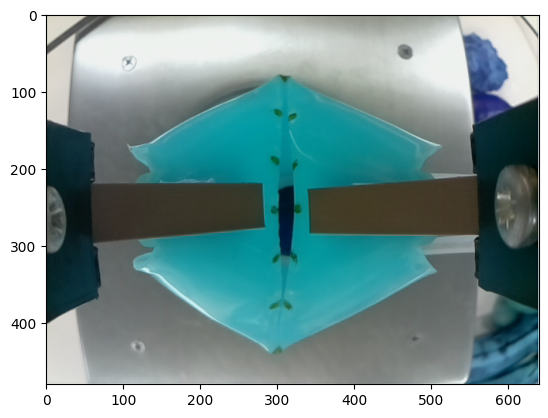

b'078.6,077.7,0317.6,0317.8\r\n'
Data number 14
['078.6', '077.7', '0317.6', '0317.8']
b'077.0,077.0,0391.3,0256.5\r\n'
['077.0', '077.0', '0391.3', '0256.5']
Enter something: 
b'000.0,000.0,0349.6,0350.2\r\n'
[INFO] [1677542263.109517]: Image received...


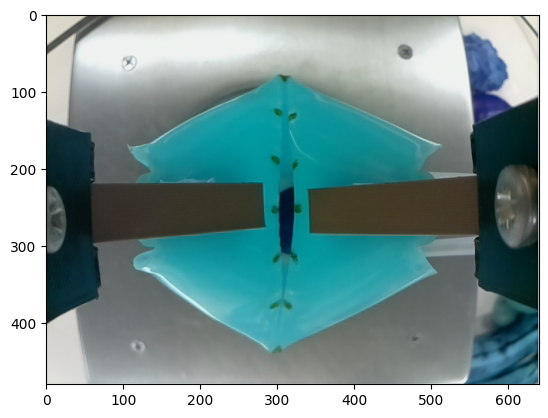

b'073.0,080.0,0315.2,0315.1\r\n'
Data number 15
['073.0', '080.0', '0315.2', '0315.1']
b'071.7,079.6,0389.0,0254.4\r\n'
['071.7', '079.6', '0389.0', '0254.4']
Enter something: 
b'000.0,000.0,0357.9,0358.3\r\n'
[INFO] [1677542277.606293]: Image received...


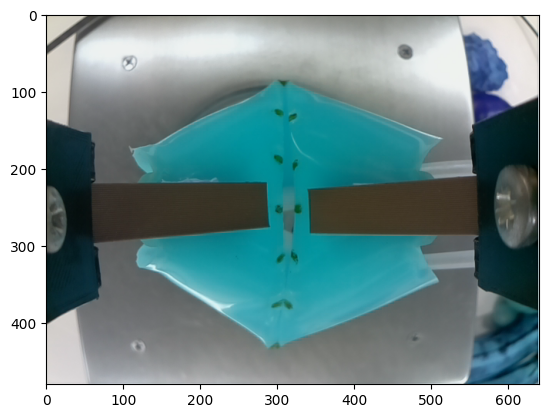

b'057.2,072.3,0275.5,0275.7\r\n'
Data number 16
['057.2', '072.3', '0275.5', '0275.7']
b'056.6,073.3,0349.2,0214.7\r\n'
['056.6', '073.3', '0349.2', '0214.7']
Enter something: 
b'000.0,000.0,0359.0,0359.3\r\n'
[INFO] [1677542294.342518]: Image received...


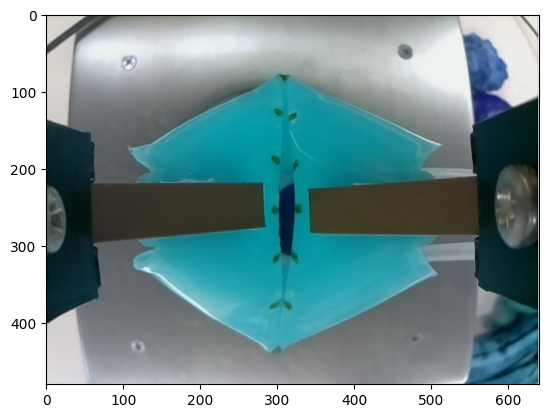

b'085.7,065.7,0317.5,0317.8\r\n'
Data number 17
['085.7', '065.7', '0317.5', '0317.8']
b'083.7,061.1,0391.3,0257.0\r\n'
['083.7', '061.1', '0391.3', '0257.0']
Enter something: 
b'000.0,000.0,0355.3,0356.0\r\n'
[INFO] [1677542306.860736]: Image received...


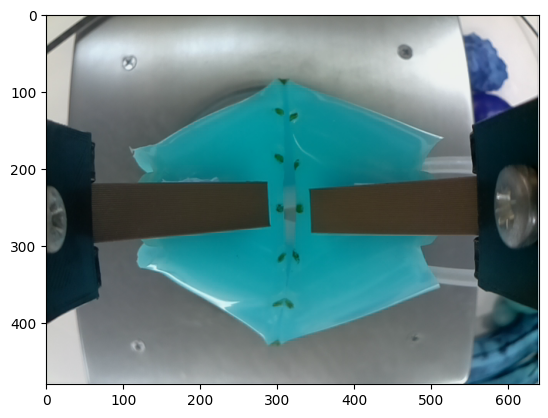

b'004.2,010.2,0269.4,0269.4\r\n'
Data number 18
['004.2', '010.2', '0269.4', '0269.4']
b'004.7,010.4,0341.3,0205.7\r\n'
['004.7', '010.4', '0341.3', '0205.7']
Enter something: 
b'000.0,000.0,0357.0,0357.5\r\n'
[INFO] [1677542321.360349]: Image received...


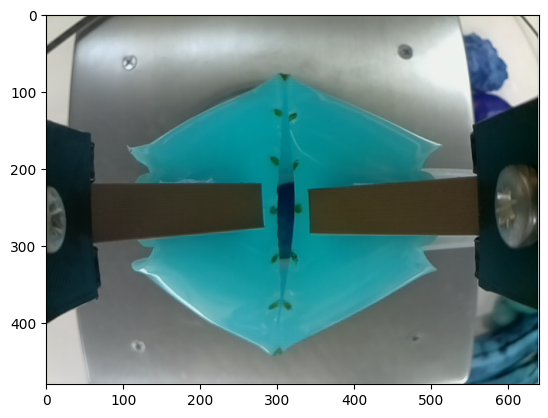

b'091.3,062.0,0331.3,0331.3\r\n'
Data number 19
['091.3', '062.0', '0331.3', '0331.3']
b'090.3,063.0,0404.3,0270.0\r\n'
['090.3', '063.0', '0404.3', '0270.0']
Enter something: 
b'000.0,000.0,0359.7,0360.1\r\n'
[INFO] [1677542343.863967]: Image received...


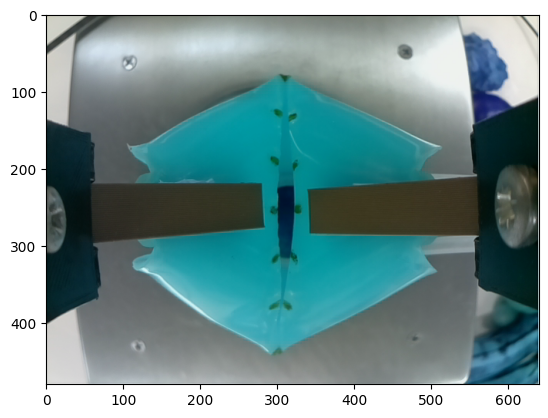

b'084.4,070.8,0325.4,0325.7\r\n'
Data number 20
['084.4', '070.8', '0325.4', '0325.7']
b'083.9,070.2,0397.9,0263.4\r\n'
['083.9', '070.2', '0397.9', '0263.4']
Enter something: 
b'000.0,000.0,0358.7,0359.3\r\n'
[INFO] [1677542360.613485]: Image received...


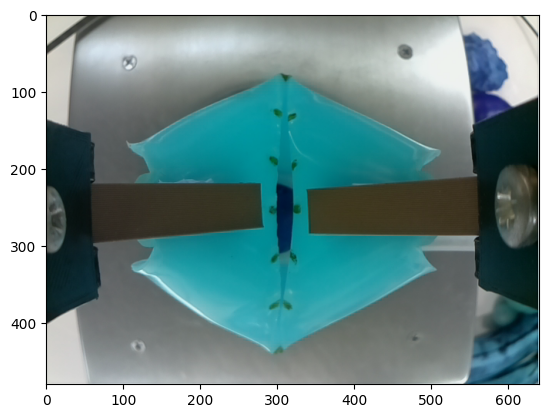

b'072.7,071.2,0326.3,0326.0\r\n'
Data number 21
['072.7', '071.2', '0326.3', '0326.0']
b'071.5,069.9,0394.6,0260.2\r\n'
['071.5', '069.9', '0394.6', '0260.2']
Enter something: 
b'000.0,000.0,0355.1,0355.0\r\n'
[INFO] [1677542373.113226]: Image received...


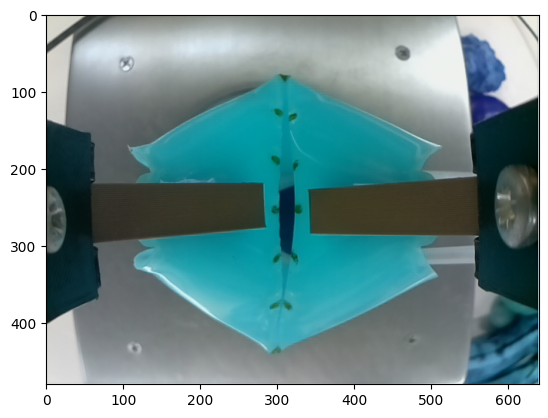

b'081.5,064.7,0316.5,0317.0\r\n'
Data number 22
['081.5', '064.7', '0316.5', '0317.0']
b'079.2,062.7,0390.2,0255.9\r\n'
['079.2', '062.7', '0390.2', '0255.9']
Enter something: 
b'000.0,000.0,0358.2,0358.8\r\n'
[INFO] [1677542390.365125]: Image received...


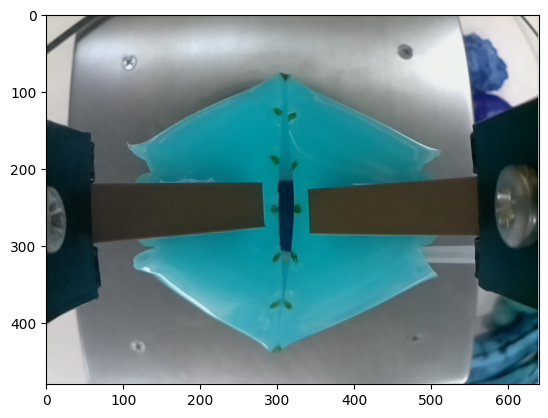

b'068.5,072.0,0320.4,0320.6\r\n'
Data number 23
['068.5', '072.0', '0320.4', '0320.6']
b'069.6,070.8,0393.2,0258.8\r\n'
['069.6', '070.8', '0393.2', '0258.8']
Enter something: 
b'000.0,000.0,0351.6,0350.4\r\n'
[INFO] [1677542402.113437]: Image received...


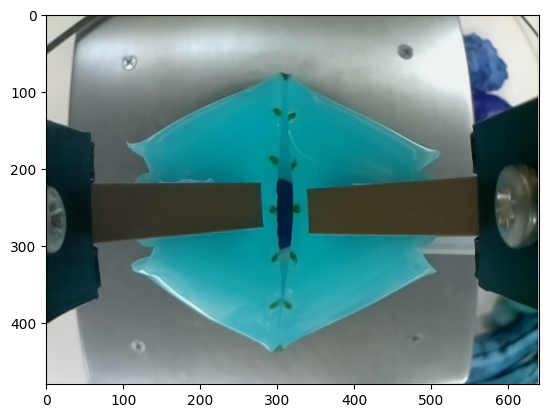

b'064.3,070.8,0322.6,0322.6\r\n'
Data number 24
['064.3', '070.8', '0322.6', '0322.6']
b'059.8,071.2,0392.1,0257.8\r\n'
['059.8', '071.2', '0392.1', '0257.8']
Enter something: 
b'000.0,000.0,0351.6,0352.3\r\n'
[INFO] [1677542413.845619]: Image received...


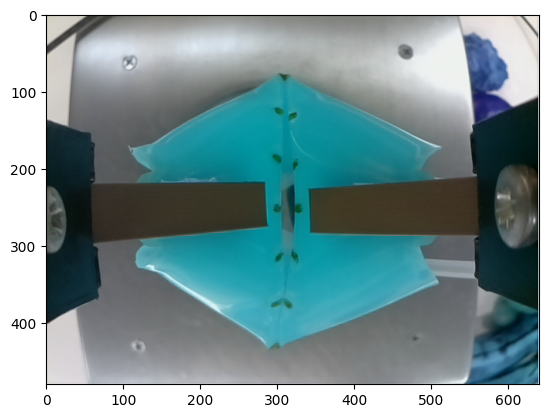

b'065.0,076.5,0301.1,0301.2\r\n'
Data number 25
['065.0', '076.5', '0301.1', '0301.2']
b'071.5,073.9,0373.7,0239.5\r\n'
['071.5', '073.9', '0373.7', '0239.5']
Enter something: 
b'000.0,000.0,0350.9,0351.5\r\n'
[INFO] [1677542425.856732]: Image received...


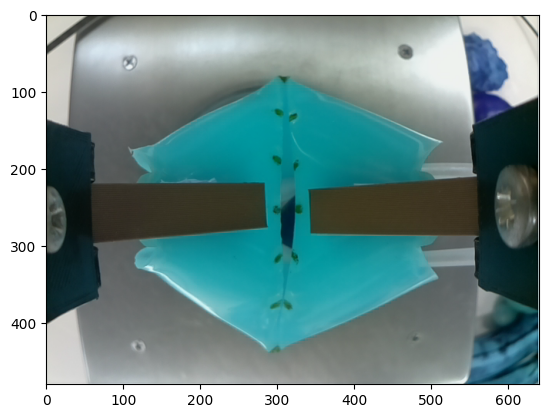

b'062.8,074.3,0305.4,0305.8\r\n'
Data number 26
['062.8', '074.3', '0305.4', '0305.8']
b'062.6,073.9,0380.3,0246.1\r\n'
['062.6', '073.9', '0380.3', '0246.1']
Enter something: 
b'000.0,000.0,0352.4,0353.2\r\n'
[INFO] [1677542438.117536]: Image received...


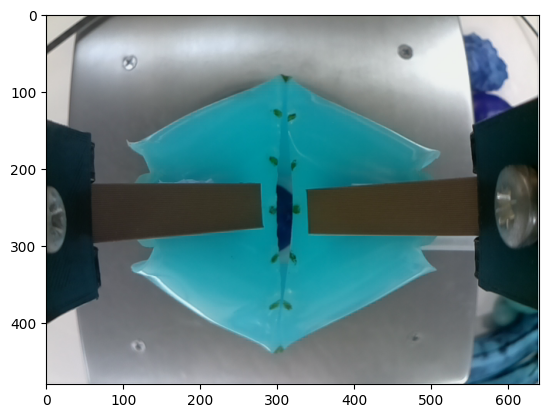

In [ ]:
class Nodo(object):
    def __init__(self, dxl_motor):
        
        self.state = 0
        
        self.input_thread = threading.Thread(target=self.get_input)
        self.input_thread.daemon = True
        self.input_thread.start()
        
        self.image_array = []
        self.pressure_reading_1 = []
        self.pressure_reading_2 = []
        self.force_reading_1 = []
        self.force_reading_2 = []
        self.weight_reading_1 = []
        self.weight_reading_2 = []
        
        self.command = '0'
        self.take_photo = '0'
        self.dxl_motor = dxl_motor
        self.initialise_motor()
        
        self.ser = serial.Serial('/dev/ttyACM0', 57600, timeout=1)
        self.initialise_arduino()
        
        self.br = CvBridge()

        self.loop_rate = rospy.Rate(4)

        # Publishers
        self.pub = rospy.Publisher('number_command', Float64, queue_size=10)

        # Subscribers
        rospy.Subscriber("/image_capture",Image,self.callback)
    
    def initialise_arduino(self):
        time.sleep(2) # wait for the arduino to initialise
        self.ser.read(200) # clear the serial buffer
    
    def untare_read_arduino(self):
        # 0: clear tare and read, 1: tare and read, 2: read
        self.ser.write(b'0')
        time.sleep(0.1)
        return self.ser.read(40)
    
    def tare_read_arduino(self):
        # 0: clear tare and read, 1: tare and read, 2: read
        self.ser.write(b'1')
        time.sleep(0.1)
        return self.ser.read(40)
    
    def read_arduino(self):
        # 0: clear tare and read, 1: tare and read, 2: read
        self.ser.write(b'2')
        time.sleep(0.1)
        return self.ser.read(40)
    
    def initialise_motor(self):
        self.dxl_motor.set_current_position_mode()
        self.dxl_motor.read_operation_mode()
        self.dxl_motor.set_goal_current(50)
        
    def move_jaw(self, position):
        self.dxl_motor.torque_enable()
#         print(f"current position is {self.dxl_motor.read_present_position()}")
        self.dxl_motor.set_goal_position(position)
    
    def disable_jaw(self):
        self.dxl_motor.torque_disable()
    
    def get_input(self):
        while True:
            self.command = input("Enter something: ")
            time.sleep(1)
    
    def callback(self, msg):
        rospy.loginfo('Image received...')
        self.image = self.br.imgmsg_to_cv2(msg)
        self.image_array.append(self.image)
        plt.imshow(self.image)
        plt.show()
    
    def store_arduino_data(self, data):
        text = re.findall('\d+\.\d+', data.decode("utf-8"))
        print(text)
        self.pressure_reading_1.append(float(text[0]))
        self.pressure_reading_2.append(float(text[1]))
        self.force_reading_1.append(float(text[2]))
        self.force_reading_2.append(float(text[3]))
    
    def store_arduino_data_weight(self, data):
        text = re.findall('\d+\.\d+', data.decode("utf-8"))
        print(text)
        self.weight_reading_1.append(float(text[2]))
        self.weight_reading_2.append(float(text[3]))
    
    def save_data(self):
        image_name = []
        directory = './Grasp_dataset_5/Grasp_dataset_fig/'
        
        start_number = 0
        
        for i in range(0, len(self.image_array)):
            image_name.append('Fiimage' + str(i+start_number).zfill(3) + '.jpg')
            cv2.imwrite(directory +'Fiimage' + str(i+start_number).zfill(3) + '.jpg', my_node.image_array[i])
        
        header = ['image_name', 'weight_reading_1', 'weight_reading_2', 'pressure_reading_1', 'pressure_reading_2', 'force_reading_1', 'force_reading_2', 'label']
        grasp_df = pd.concat([pd.Series(image_name), pd.Series(self.weight_reading_1), pd.Series(self.weight_reading_2), pd.Series(self.pressure_reading_1), pd.Series(self.pressure_reading_2), pd.Series(self.force_reading_1), pd.Series(self.force_reading_2), pd.Series(np.repeat('fig', len(self.image_array)))], axis=1, keys=header)
        
        combined_df_set = pd.read_csv(directory + 'Grasp_dataset_fig.csv')
        
        combined_df_set = pd.concat([combined_df_set, grasp_df], axis=0)
        
        combined_df_set.to_csv(directory + 'Grasp_dataset_fig.csv', index=False)
        
    def start(self):
        
        time.sleep(1)
        self.move_jaw(0)
        time.sleep(2)
        print("Taring load cell...")
        self.tare_read_arduino()
        time.sleep(0.5)
        self.move_jaw(200)
            
        rospy.loginfo("Timing images")

        while not rospy.is_shutdown():
            
            if self.command == '':
                self.command = '0'
                print(self.untare_read_arduino())
                time.sleep(0.5)
                self.move_jaw(1900)
                time.sleep(1.6)
                self.pub.publish(5201314)
                data = self.read_arduino()
                print(data)
                print('Data number ' + str(len(self.image_array)))
                self.store_arduino_data(data)
                time.sleep(0.5)

                time.sleep(1.9)
                self.pub.publish(1314)
                data = self.read_arduino()
                print(data)
                self.store_arduino_data_weight(data)
                time.sleep(2.8)
                self.move_jaw(200)

            elif self.command == '3':
                self.disable_jaw()
        
            self.loop_rate.sleep()

if __name__ == '__main__':
    rospy.init_node("command_publisher", anonymous=True)
    dxl_motor = Dynamixel_motor(1, 57600, '/dev/ttyUSB0')
    my_node = Nodo(dxl_motor)
    my_node.start()

In [ ]:
my_node.save_data()